Hybrid DG for elliptic equations
===
$\DeclareMathOperator{\opdiv}{div}$

The discretization of elliptic operators by DG is more tricky. Instead of the DG method, we go directly to the hybrid DG method (HDG). 
A notebook on standard-DG is [here](elliptic_stdDG.ipynb).




The HDG method involves discontinuous polynomials on elements, and additional polynomials on the edges (or faces, in 3D).

We start from the Poisson equation
$$
-\Delta u = f
$$

multiply by discontinuous test functions, integrate by parts on every element:

$$
\sum_T \int_T \nabla u \nabla v - \int_{\partial T} \frac{\partial u}{\partial n} v = \int_\Omega f v
$$

Since the normal-derivatives are continuous from element to element, we can smuggle in a single-valued test-function $\widehat v$ on every edge:

$$
\sum_T \int_T \nabla u \nabla v - \int_{\partial T} \frac{\partial u}{\partial n} (v-\widehat{v}) = \int_\Omega f v
$$

This is a non-symmetric bilinear-form for the self-adjoint Poisson operator, what we don't like. For the true solution $u$, the solution on the elements restricted to the edges is the same as the solution restricted to the edges, we are adding a zero term:

$$
\sum_T \int_T \nabla u \nabla v 
- \int_{\partial T} \frac{\partial u}{\partial n} (v-\widehat{v}) 
- \int_{\partial T} \frac{\partial v}{\partial n} (u-\widehat{u}) 
= \int_\Omega f v
$$

This form may not be coercive, and we have to add a stabilization term:

$$
\sum_T \int_T \nabla u \nabla v 
- \int_{\partial T} \frac{\partial u}{\partial n} (v-\widehat{v}) 
- \int_{\partial T} \frac{\partial v}{\partial n} (u-\widehat{u}) 
+ \int_{\partial T} \frac{\alpha p^2}{h} (u-\widehat{u}) (v-\widehat{v})
= \int_\Omega f v
$$

Here, $h$ is the element-size, $p$ the polynomial order, and $\alpha$ a sufficiently large stabilization parameter (typically 3 in 2D and 10 in 3D). This 'sufficiently large' condition is a drawback of the so called interior penalty version of DG/HDG, but there exist more sophisticated, robust versions.

In [1]:
from ngsolve import *
from netgen.geom2d import unit_square
from ngsolve.webgui import Draw
mesh = Mesh(unit_square.GenerateMesh(maxh=0.1))

In [2]:
order = 3
fes1 = L2(mesh, order=order)
fes2 = FacetFESpace(mesh, order=order, dirichlet="left|bottom", 
                    highest_order_dc=False)
fes = fes1 * fes2

In [3]:
u,uhat = fes.TrialFunction()
v,vhat = fes.TestFunction()

h = specialcf.mesh_size
n = specialcf.normal(2)
alpha = 3
dS = dx(element_vb=BND)

a = BilinearForm(fes, condense=False)
a += grad(u)*grad(v)*dx
a += (-n*grad(u)*(v-vhat)-n*grad(v)*(u-uhat))*dS
a += alpha*(order+1)**2/h*(u-uhat)*(v-vhat)*dS

f = LinearForm(fes)
f += 1*v*dx

a.Assemble()
f.Assemble()

print ("ndof: ", fes.ndof)
print ("non-zero(A):", a.mat.nze)
print ("non-zero(Inv):", a.mat.Inverse(fes.FreeDofs(a.condense), "sparsecholesky").nze)

ndof:  3792
non-zero(A): 107040
non-zero(Inv): 76416


In [4]:
gfu = GridFunction(fes)
if not a.condense:
    gfu.vec.data = a.mat.Inverse(fes.FreeDofs()) * f.vec
else:
    solvers.BVP(bf=a, lf=f, gf=gfu)
Draw (gfu.components[0]);

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

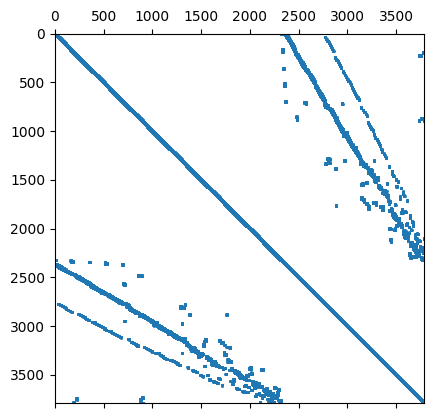

In [5]:
import scipy.sparse as sp
import matplotlib.pyplot as plt
scipymat = sp.csr_matrix(a.mat.CSR())
plt.spy(scipymat, precision=1e-10, markersize=1);